In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.fftpack
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

from sklearn import linear_model

from datetime import datetime

%matplotlib inline

In [78]:
energy = pd.read_csv('data/production_consumption_2012_2016_scaled.csv', sep=';', decimal=',')
energy['timestamp'] = pd.to_datetime(energy['cet_cest_timestamp'])
energy.drop(['utc_timestamp', 'cet_cest_timestamp'], axis=1, inplace=True)
energy.set_index('timestamp', inplace=True)

energy_train = energy[(energy.index >= datetime(2015,12,31)) & (energy.index < datetime(2016,1,1))]
energy_test = energy[(energy.index >= datetime(2016,1,1)) & (energy.index < datetime(2017,1,1))]

In [51]:
weather_b = pd.read_csv('data/weather_UTC_2012-2016_Berlin.csv', sep=';', decimal=',')
weather_b.VALUE_TIME = pd.to_datetime(weather_b.VALUE_TIME)
weather_b.set_index('VALUE_TIME', inplace=True)
weather_b_train = weather_b[(weather_b.index>=datetime(2015, 1, 1)) & (weather_b.index < datetime(2016,1,1))]
weather_b_test = weather_b[(weather_b.index>=datetime(2016, 1, 1)) & (weather_b.index < datetime(2017,1,1))]

weather_m = pd.read_csv('data/weather_UTC_2012-2016_Munich.csv', sep=';', decimal=',')
weather_m.VALUE_TIME = pd.to_datetime(weather_m.VALUE_TIME)
weather_m.set_index('VALUE_TIME', inplace=True)
weather_m_train = weather_m[(weather_m.index>=datetime(2015, 1, 1)) & (weather_m.index < datetime(2016,1,1))]
weather_m_test = weather_m[(weather_m.index>=datetime(2016, 1, 1)) & (weather_m.index < datetime(2017,1,1))]

weather_d = pd.read_csv('data/weather_UTC_2012-2016_Dusseldorf.csv', sep=';', decimal=',')
weather_d.VALUE_TIME = pd.to_datetime(weather_d.VALUE_TIME)
weather_d.set_index('VALUE_TIME', inplace=True)
weather_d_train = weather_d[(weather_d.index>=datetime(2015, 1, 1)) & (weather_d.index < datetime(2016,1,1))]
weather_d_test = weather_d[(weather_d.index>=datetime(2016, 1, 1)) & (weather_d.index < datetime(2017,1,1))]

In [79]:
model = ARIMA(energy_train['consumption'], order=(2, 0, 0), freq='H')
#exog=pd.concat([weather_m_train[['global_rad','wind_speed_10m','precip_1h','t_2m']], 
#                              weather_b_train[['global_rad','wind_speed_10m','precip_1h', 't_2m']],
#                              weather_d_train[['global_rad','wind_speed_10m','precip_1h', 't_2m']], 
#                              ], axis=1))  
ARIMA_fitted = model.fit(disp=-1)  

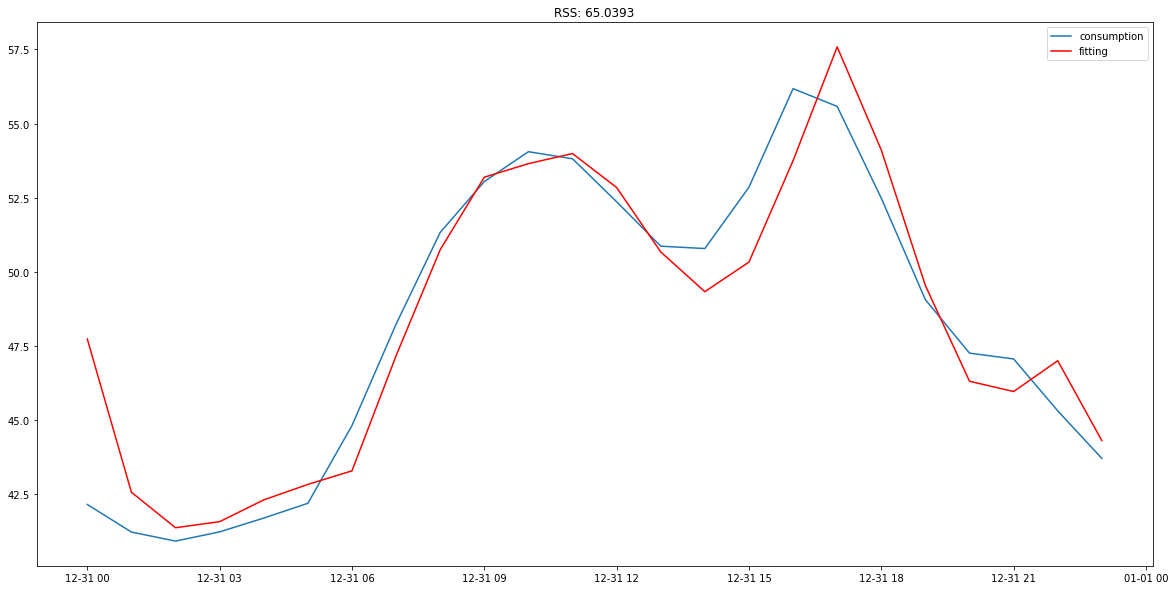

In [80]:
plt.figure(figsize=(20,10))
plt.plot(energy_train['consumption'], label='consumption')
plt.plot(ARIMA_fitted.fittedvalues[:30*24], color='red', label='fitting')
plt.title('RSS: %.4f'% sum((ARIMA_fitted.fittedvalues-energy_train['consumption'])**2))
plt.legend()

In [81]:
lag = 24

In [73]:
test_exogen = pd.concat([weather_d_test[['global_rad','wind_speed_10m','precip_1h','t_2m']][:lag],
           weather_m_test[['global_rad','wind_speed_10m','precip_1h','t_2m']][:lag],
          weather_b_test[['global_rad','wind_speed_10m','precip_1h','t_2m']][:lag]],axis=1)

In [82]:
start_idx = energy_train.shape[0]
end_idx = start_idx + lag - 1
prediction = ARIMA_fitted.predict(start=start_idx, end=end_idx) #exog=test_exogen)

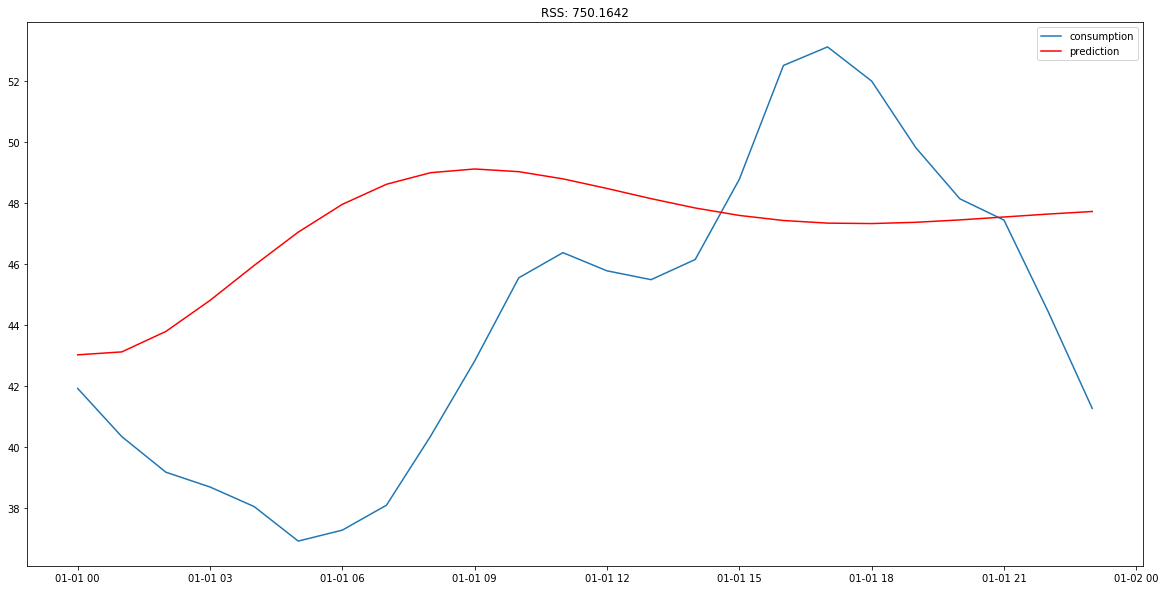

In [83]:
plt.figure(figsize=(20,10))
plt.plot(energy_test['consumption'][:24], label='consumption')
plt.plot(prediction, color='red', label='prediction')
plt.title('RSS: %.4f'% sum((prediction-energy_test['consumption'][:24])**2))
plt.legend()